In [2]:
!ls /mnt/chicm/data/landmark/train

256	     tars_256		    top5000_classes.csv  train_5000.csv
download.py  top10000_classes.csv   train_10000.csv	 train_attribution.csv
download.sh  top1000_classes.csv    train_1000.csv	 train.csv
images	     top203094_classes.csv  train_203094.csv
tars	     top50000_classes.csv   train_50000.csv


In [3]:
!ls /mnt/chicm/data/landmark/test

images_jpg					    test.csv
images_jpg_256					    test_images_tiff.tar
images_tiff					    test_imgs_jpg.tar
landmark-recognition-challenge-image-downloader.py


In [4]:
!ls /mnt/chicm/data/landmark/vectors

FeatureNet_se_resnext50_32x4d.index  testvect.index  testvect_ivf.index


In [1]:
import os
import torch
import models
import settings
import faiss

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np
import pandas as pd
import cv2

In [3]:
df = pd.read_csv(os.path.join(settings.DATA_DIR, 'test', 'test.csv'))
df.head()

id                                                url
0  cb9998b8cdaf6235  https://lh3.googleusercontent.com/-q8B91vDIQZY...
1  30728cf6e50a6bc6  https://lh3.googleusercontent.com/-91gJSKTgv5Q...
2  16afbc86b710337d  https://lh3.googleusercontent.com/-GHZdXuf2wMg...
3  d29b2166cf522450  https://lh3.googleusercontent.com/-cWDnYNQhyws...
4  dd5c03b20c21cfba  https://lh3.googleusercontent.com/-PSLN6BloM-k...

In [4]:
def get_random_test_file():
    img_id = df.sample(1).iloc[0].id
    for i in range(10):
        fn = os.path.join(settings.TEST_IMG_DIR, str(i), '{}.jpg'.format(img_id))
        if os.path.isfile(fn):
            return fn
    raise AssertionError('file not found')

def show_img(fn):
    pil_im = Image.open(fn) #Take jpg + png
    im_array = np.asarray(pil_im)
    plt.imshow(im_array)
    plt.show()

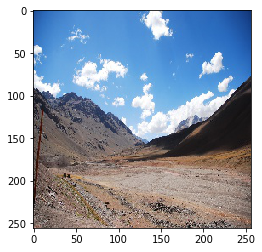

In [5]:
show_img(get_random_test_file())

In [6]:
df_train = pd.read_csv(os.path.join(settings.DATA_DIR, 'train', 'train.csv'))

In [7]:
df_classes = pd.read_csv(os.path.join(settings.DATA_DIR, 'train', 'top203094_classes.csv'))

In [10]:
df_classes[:10].values

array([[138982],
       [ 62798],
       [177870],
       [176528],
       [192931],
       [126637],
       [ 83144],
       [171772],
       [ 20409],
       [151942]])

In [11]:
df_train.head()

id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
1  202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
2  3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
3  e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4  4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
1       104169  
2        37914  
3       102140  
4         2474

In [12]:
def show_imgs(fns, titles=None):
    plt.figure(figsize=(20,20))
    columns = 5
    for i, fn in enumerate(fns):
        plt.subplot(len(fns) / columns + 1, columns, i + 1)
        img = cv2.imread(fn)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img)

def get_train_fn(img_id):
    return os.path.join(settings.TRAIN_IMG_DIR, img_id[0], img_id[1], img_id[2], '{}.jpg'.format(img_id))


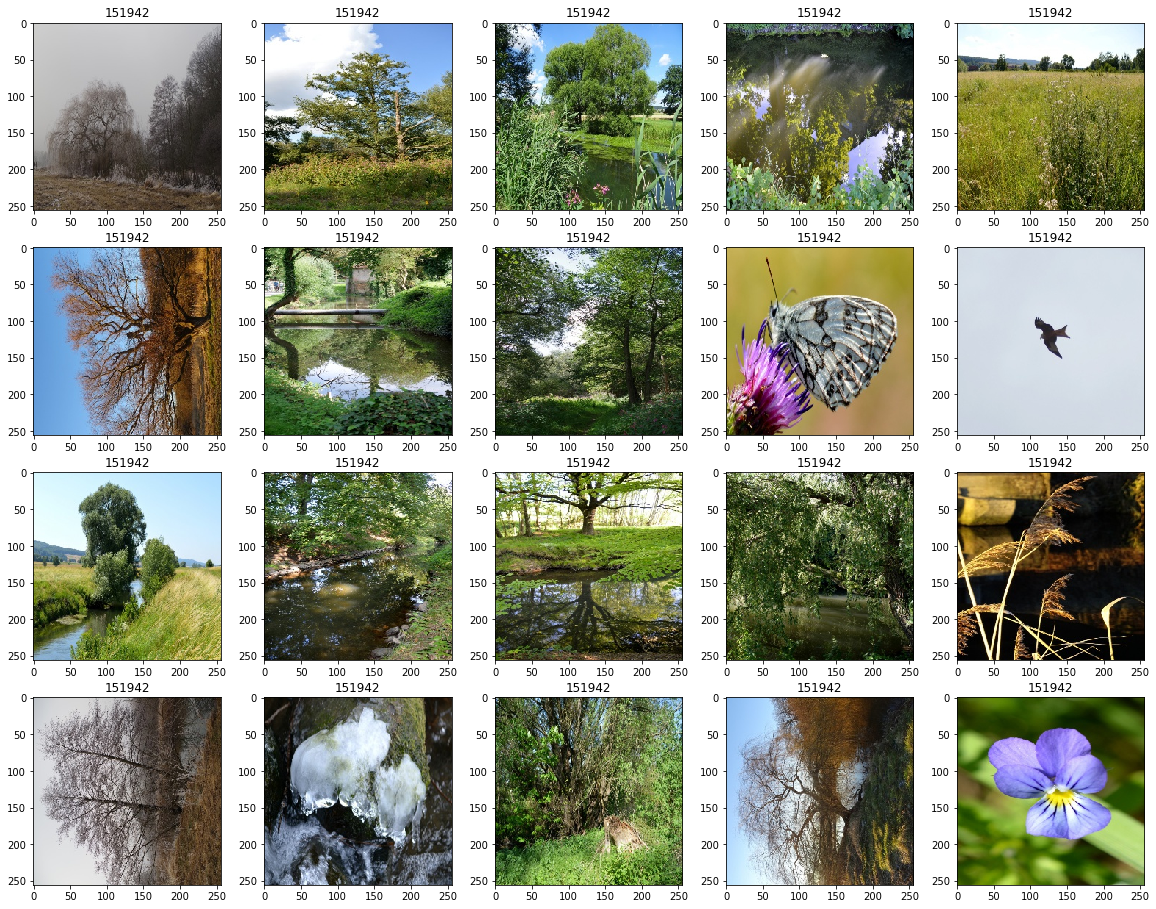

In [20]:
def show_random_landmarks(landmark_id=None):
    if landmark_id is None:
        landmark_id = df_train.sample(1).landmark_id.values[0]
    img_ids = df_train[df_train.landmark_id == landmark_id].sample(20).id.values
    fns = [get_train_fn(x) for x in img_ids]
    show_imgs(fns, [landmark_id]*20)
show_random_landmarks(151942)

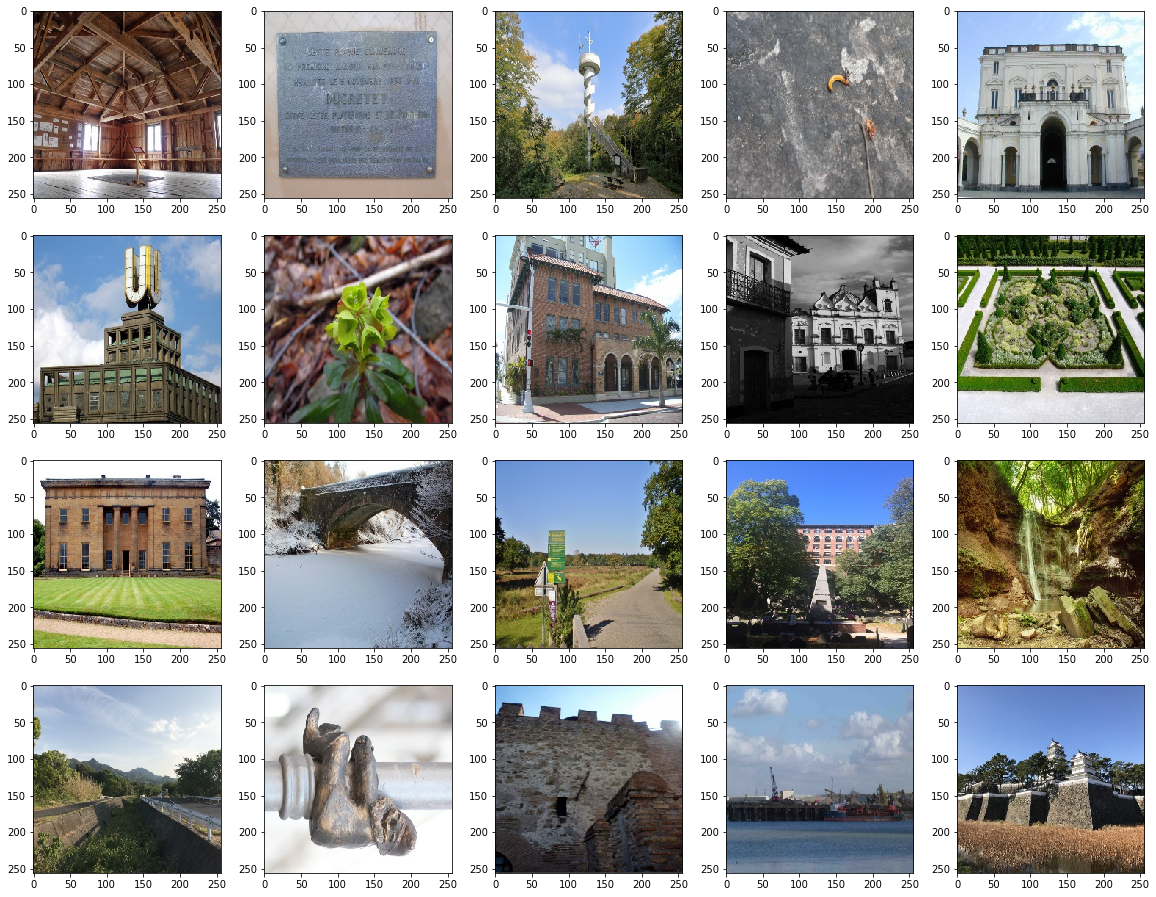

In [151]:
# show random pictures
img_ids = df_train.sample(20).id.values
fns = [get_train_fn(x) for x in img_ids]
show_imgs(fns)

In [67]:
from torchvision import transforms
def get_img_tensor(fn):
    img = cv2.imread(fn)
    img = transforms.functional.to_tensor(img)
    img = transforms.functional.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return img.unsqueeze(0)
 

In [60]:
fn_test = get_random_test_file()
fn_test

'/mnt/chicm/data/landmark/test/images_jpg_256/4/f29000f613ed7144.jpg'

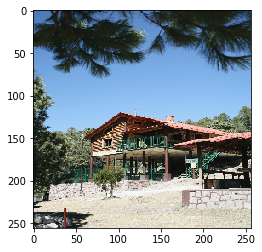

In [61]:
show_img(fn_test)

In [69]:
test_img_tensor = get_img_tensor(fn_test).cuda()
test_img_tensor.size()

torch.Size([1, 3, 256, 256])

In [63]:
from argparse import Namespace
from models import create_model, FeatureNet

def create_feature_model():
    args = Namespace()
    args.init_ckp = None
    args.backbone = 'se_resnext50_32x4d'
    args.ckp_name = 'best_pretrained.pth'
    args.predict = True
    args.num_classes = 50000

    cls_model, _ = create_model(args)
    model = FeatureNet(args.backbone, cls_model=cls_model)
    model = model.cuda()
    model.eval()
    return model

In [64]:
model = create_feature_model()

num_classes: 50000
model file: /mnt/chicm/data/landmark/models/LandmarkNet_se_resnext50_32x4d_50000/best_pretrained.pth, exist: True
loading /mnt/chicm/data/landmark/models/LandmarkNet_se_resnext50_32x4d_50000/best_pretrained.pth...


In [70]:
vector = model(test_img_tensor)
vector.size()

torch.Size([1, 2048])

# Search nearest images in faise

In [71]:
index = faiss.read_index(os.path.join(settings.VECTOR_DIR, 'FeatureNet_se_resnext50_32x4d.index'))


In [116]:
q = np.random.random((1,2048)).astype('float32')
D, I = index.search(q, 5)
print('D:', D)
print('I:', I)

D: [[656.15393 656.47644 656.5151  656.5458  656.8772 ]]
I: [[1857020 3335318 2927664 3014700 3393735]]


In [159]:
def get_fns_by_index_ids(index_ids):
    df_res = df_train.iloc[index_ids]
    img_ids = df_res.id.values
    return [get_train_fn(x) for x in img_ids], df_res.landmark_id.values

In [160]:
def show_search_results(v, search_num=20):
    q = v.cpu().detach().numpy()
    #q = np.random.random((1,2048)).astype('float32')
    D, I = index.search(q, search_num)
    #print('D:', D)
    #print('I:', I)
    searched_fns, labels = get_fns_by_index_ids(I.squeeze())
    #print(searched_fns)
    show_imgs(searched_fns, labels)

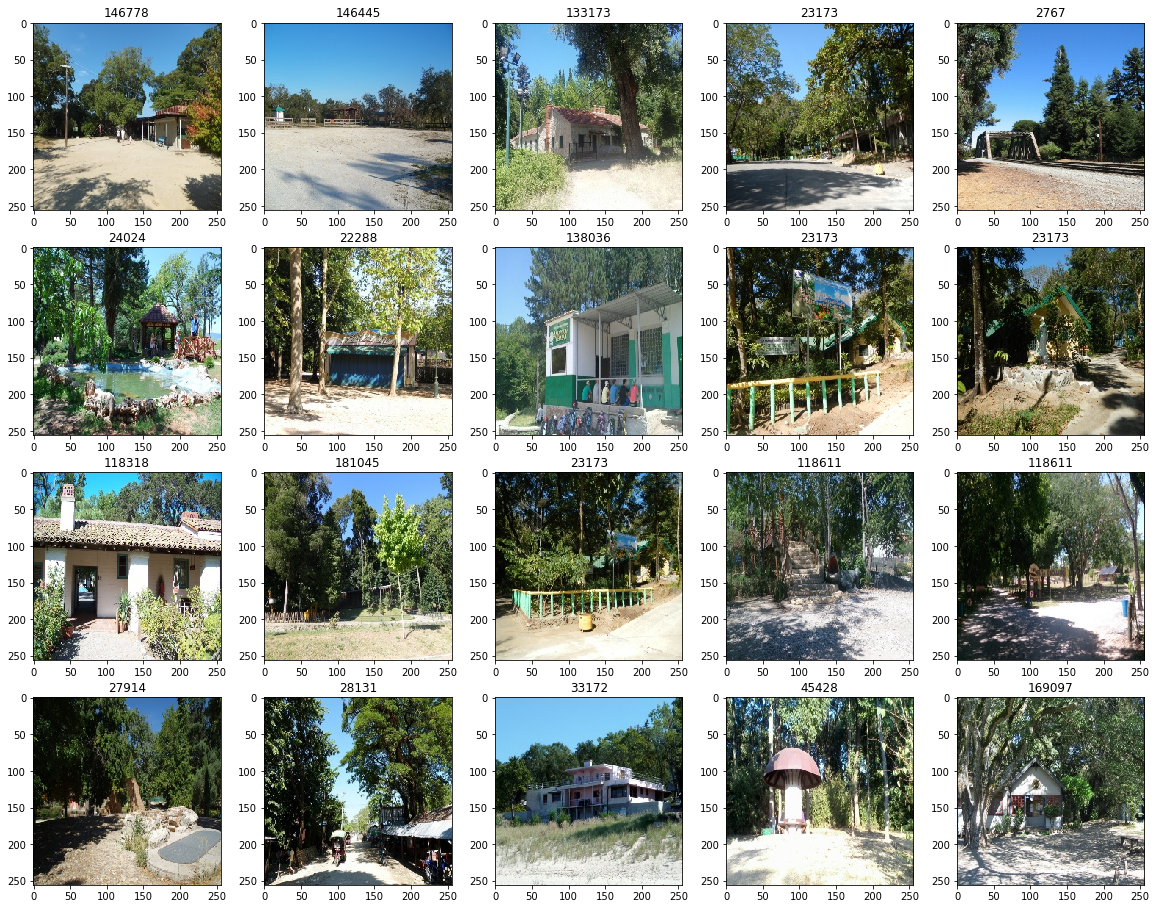

In [161]:
show_search_results(vector)

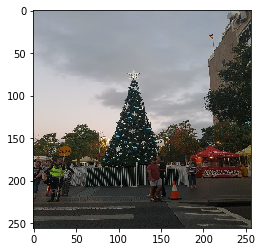

In [172]:
def get_random_test_tensor():
    fn_test = get_random_test_file()
    show_img(fn_test)
    img_tensor = get_img_tensor(fn_test).cuda()
    return model(img_tensor)

v_test=get_random_test_tensor()

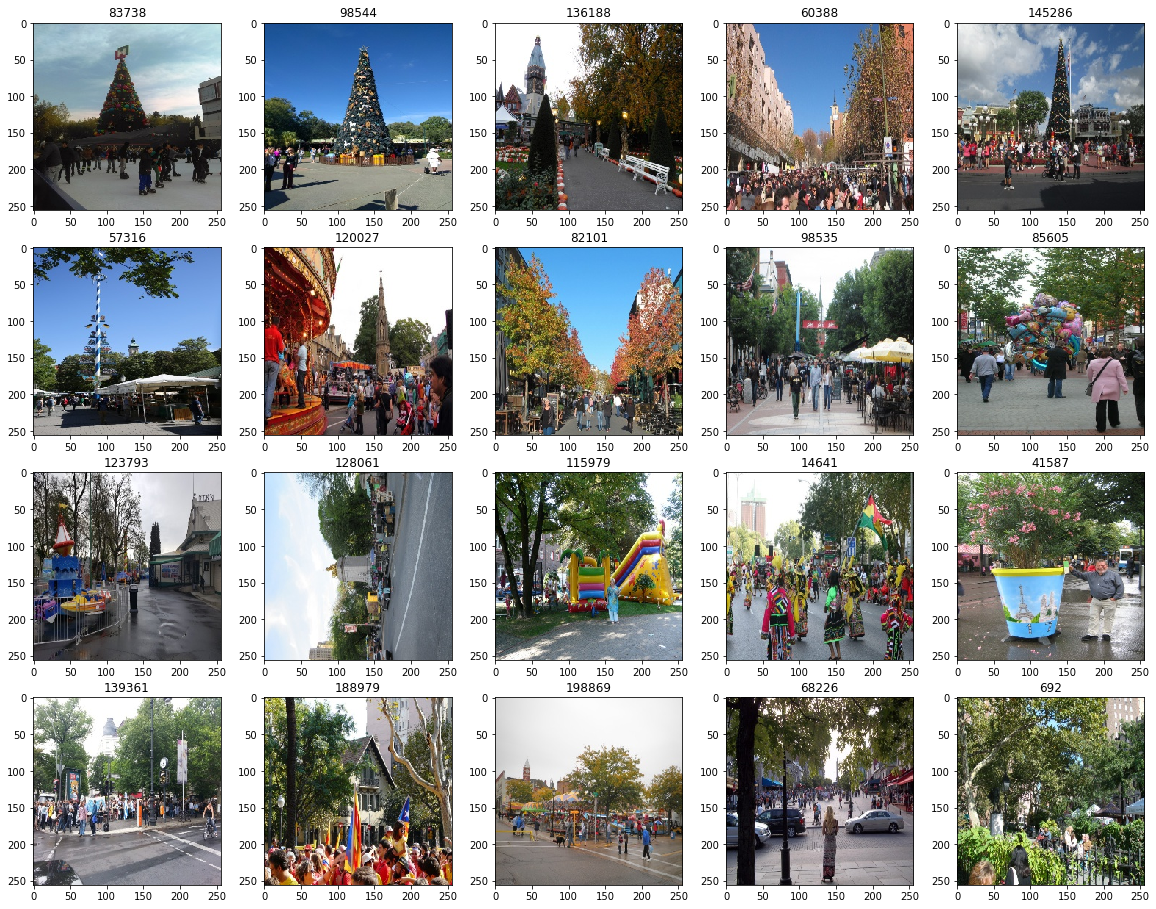

In [173]:
show_search_results(v_test)